### Célula 1: Importar Bibliotecas

Esta célula prepara nosso ambiente. Importamos as bibliotecas para análise de dados (Pandas, Numpy), visualização (Matplotlib, Seaborn) e os modelos de Machine Learning (LinearRegression, RandomForestRegressor) e métricas (r2_score).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

!pip install pytrends pandas

### Célula 2: Carregar Dados Internos (Pedidos)

Carregamos o `pedidos_categorizados.csv` (nossas vendas reais) e garantimos que a coluna de data esteja no formato correto.

In [ ]:
try:
    df_pedidos =pd.read_csv('https://raw.githubusercontent.com/2025-2-NCC5/Projeto2/main/cannoli_atualizado.csv')
    df_pedidos['Data_Pedido'] = pd.to_datetime(df_pedidos['Data_Pedido'], dayfirst=True, format='mixed')

    print("Dados de pedidos carregados com sucesso:")
    print(df_pedidos.head())
except FileNotFoundError:
    print("Erro: Arquivo 'cannoli_atualizado.csv' não encontrado.")
    print("Por favor, faça o upload do arquivo para o ambiente do Colab.")

Dados de pedidos carregados com sucesso:
     id            name           taxid  gender dateofbirth    status  \
0  2200  Pedro Mendonça  179.342.512-08  Female  2005-08-27    active   
1  2201    Carlos Costa  130.664.878-42  Female  1994-12-07  inactive   
2  2202    Lucas Araujo  303.349.853-52    Male  2005-10-14    active   
3  2203    Camila Rocha  761.791.912-79  Female  1969-03-09   pending   
4  2204  Mariana Santos  513.327.159-67  Female  1979-06-06   pending   

  externalcode  isenriched enrichedat enrichedbt            createdat  \
0   0KZY0SUFMW       False        NaN        NaN  2025-10-27T00:00:00   
1   53SMHHQO5H       False        NaN        NaN  2025-10-10T00:00:00   
2   HQ1FE10WAN       False        NaN        NaN  2025-10-15T00:00:00   
3   9AFA7RKYHG       False        NaN        NaN  2025-10-22T00:00:00   
4   QULJ1HX9V9       False        NaN        NaN  2025-10-17T00:00:00   

       createdby            updatedat      updatedby  ID_Pedido Data_Pedido  \
0 

### Célula 3: Processar Dados Internos (Agregar por Dia)

Não podemos comparar tendências diárias com pedidos individuais. Precisamos saber o **total** de vendas de cada categoria *por dia*. Vamos agrupar (groupby) e depois "pivotar" (pivot) a tabela.

In [ ]:
# Contar quantos pedidos de cada categoria tivemos por dia
df_agg = df_pedidos.groupby(['Data_Pedido', 'Categoria_Comida']).size().reset_index(name='Total_Pedidos')

# Pivotar a tabela para o formato: Data | Pizza | Hambúrguer | Sushi
df_vendas_diarias = df_agg.pivot(index='Data_Pedido', columns='Categoria_Comida', values='Total_Pedidos').fillna(0)

# Resetar o índice para a data voltar a ser uma coluna
df_vendas_diarias = df_vendas_diarias.reset_index()

# Garantir que a data esteja sem fuso horário para o merge
df_vendas_diarias['Data_Pedido'] = pd.to_datetime(df_vendas_diarias['Data_Pedido']).dt.tz_localize(None)

print("Dados de vendas agregados por dia:")
print(df_vendas_diarias.head())

Dados de vendas agregados por dia:
Categoria_Comida Data_Pedido  Massas  Pizza  Sobremesa
0                 2025-08-11     4.0    8.0        5.0
1                 2025-08-12     0.0    4.0       11.0
2                 2025-08-13     2.0    5.0       13.0
3                 2025-08-14     2.0    6.0       11.0
4                 2025-08-15     4.0    6.0       13.0


### Célula 4: Instalar e Importar Pytrends

Esta é a primeira parte do seu código. Instalamos a biblioteca `pytrends`.

### Célula 5: Carregar Dados Externos (Google Trends)

Esta é a segunda parte do seu código. Vamos conectar e buscar os dados reais do Google Trends para os últimos 3 meses.

In [ ]:
pytrends = TrendReq(hl='pt-BR', tz=360)

keywords = ["pizza", "hambúrguer", "sushi"]

pytrends.build_payload(keywords, cat=0, timeframe='today 3-m', geo='BR', gprop='')

df_trends_raw = pytrends.interest_over_time()

print("✅ Tendências de comidas (Google Trends - últimos 3 meses):")
display(df_trends_raw.head())

✅ Tendências de comidas (Google Trends - últimos 3 meses):


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,pizza,hambúrguer,sushi,isPartial
date,,,,
2025-08-09,80,13,40,False
2025-08-10,73,10,31,False
2025-08-11,43,8,21,False
2025-08-12,41,8,20,False
2025-08-13,40,8,21,False


### Célula 6: Processar e Alinhar Dados do Google Trends

Os dados do Pytrends precisam ser "limpos" antes de podermos usá-los:
1.  Resetamos o índice (`date`) para que ele se torne uma coluna.
2.  Convertemos essa coluna de data para `datetime` e removemos o fuso horário (`tz_localize(None)`) para que ela possa ser unida com nossos dados de vendas.
3.  Renomeamos as colunas (ex: `pizza` para `pizza_trend`) para o nosso modelo.
4.  Removemos colunas que não usaremos (como `isPartial`, `nike`).

In [ ]:
df_trends = df_trends_raw.reset_index()

df_trends = df_trends.rename(columns={
    'date': 'Data_Pedido',
    'pizza': 'pizza_trend',
    'hambúrguer': 'hamburguer_trend',
    'sushi': 'sushi_trend'
})

df_trends['Data_Pedido'] = pd.to_datetime(df_trends['Data_Pedido']).dt.tz_localize(None)

colunas_para_manter = ['Data_Pedido', 'pizza_trend', 'hamburguer_trend', 'sushi_trend']
df_trends = df_trends[colunas_para_manter]

print("Dados do Google Trends processados e prontos para unir:")
print(df_trends.head())

Dados do Google Trends processados e prontos para unir:
  Data_Pedido  pizza_trend  hamburguer_trend  sushi_trend
0  2025-08-09           80                13           40
1  2025-08-10           73                10           31
2  2025-08-11           43                 8           21
3  2025-08-12           41                 8           20
4  2025-08-13           40                 8           21


### Célula 7: Unir Fontes de Dados

Agora, unimos nossas Vendas Diárias (`df_vendas_diarias`) com os dados reais do Google Trends (`df_trends`) usando a data.

In [ ]:
df_modelo = pd.merge(df_vendas_diarias, df_trends, on='Data_Pedido', how='inner')

print("Dados combinados para modelagem (Vendas + Trends):")
print(df_modelo.head())

Dados combinados para modelagem (Vendas + Trends):
  Data_Pedido  Massas  Pizza  Sobremesa  pizza_trend  hamburguer_trend  \
0  2025-08-11     4.0    8.0        5.0           43                 8   
1  2025-08-12     0.0    4.0       11.0           41                 8   
2  2025-08-13     2.0    5.0       13.0           40                 8   
3  2025-08-14     2.0    6.0       11.0           45                 9   
4  2025-08-15     4.0    6.0       13.0           65                 9   

   sushi_trend  
0           21  
1           20  
2           21  
3           23  
4           31  


### Célula 8: Análise Exploratória (EDA) - Função `freq`

Esta é a sua função `freq` original. Vamos usá-la para analisar a distribuição das nossas categorias de comida nos dados de pedidos.

In [ ]:
def freq(x: pd.Series, plot=False):
    contagem = x.value_counts(dropna=False)
    percentual = round((contagem / x.shape[0]) * 100, 3)

    res = pd.DataFrame({'n': contagem, 'perc': percentual})
    res.index.name = 'values'

    if plot:
        sns.countplot(x=x)
        plt.show()

    return res

### Célula 9: EDA - Frequência de Categorias

Analisando o dataset de pedidos original para ver quais categorias são mais vendidas.

Frequência de Pedidos por Categoria (dataset original):


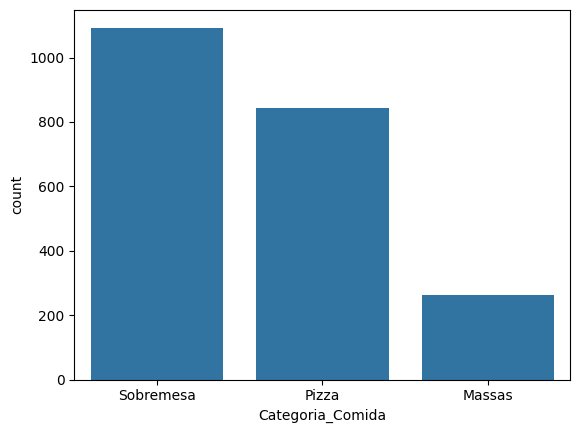

,n,perc
values,,
Sobremesa,1093,49.682
Pizza,844,38.364
Massas,263,11.955


In [ ]:
print("Frequência de Pedidos por Categoria (dataset original):")
display(freq(df_pedidos['Categoria_Comida'], plot=True))

### Célula 10: EDA - Resumo Estatístico

Adaptamos esta célula (que antes olhava o `taxid`) para olhar as colunas que vamos usar no modelo: `Pizza` (vendas) e `pizza_trend` (buscas).

In [ ]:
print("Resumo estatístico das vendas de Pizza (por dia):")
print(df_modelo['Pizza'].describe())
print("\nResumo estatístico das buscas por Pizza (Trend):")
print(df_modelo['pizza_trend'].describe())

Resumo estatístico das vendas de Pizza (por dia):
count    91.000000
mean      9.274725
std       3.238882
min       3.000000
25%       7.000000
50%       9.000000
75%      11.000000
max      19.000000
Name: Pizza, dtype: float64

Resumo estatístico das buscas por Pizza (Trend):
count     91.000000
mean      56.076923
std       16.409503
min       40.000000
25%       43.000000
50%       46.000000
75%       69.000000
max      100.000000
Name: pizza_trend, dtype: float64


### Célula 11: EDA - Boxplot

Vamos usar o boxplot para ver a distribuição das nossas duas variáveis principais (vendas e buscas).

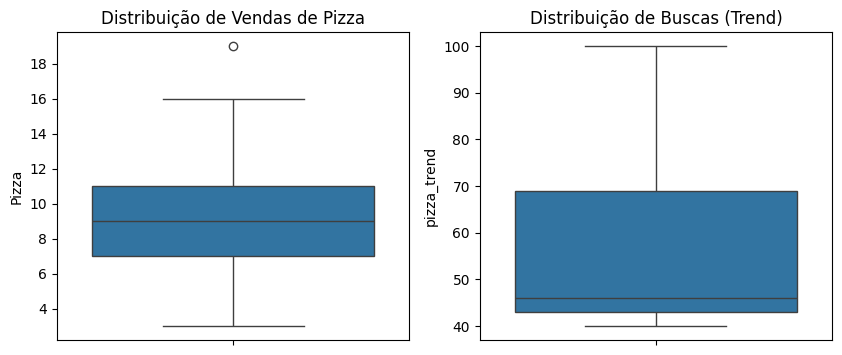

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_modelo['Pizza'])
plt.title('Distribuição de Vendas de Pizza')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_modelo['pizza_trend'])
plt.title('Distribuição de Buscas (Trend)')
plt.show()

### Célula 12: Definir X e y (O Foco do Projeto)

Definimos o que queremos prever e o que vamos usar para prever.
* **`y` (alvo):** `Pizza` (o número de pedidos).
* **`X` (features):** `pizza_trend` (o dado do Google).

In [ ]:
y = df_modelo['Pizza']

X = df_modelo[['pizza_trend']]

print(f"Formato de X: {X.shape}")
print(f"Formato de y: {y.shape}")

Formato de X: (91, 1)
Formato de y: (91,)


### Célula 13: Dividir Dados em Treino e Teste

Dividimos os dados para treinar e testar os modelos de forma justa.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Célula 14: Modelo 1 (Baseline) - Regressão Linear

Treinamos o primeiro modelo. A Regressão Linear é a melhor ferramenta para medir a **correlação** e responder à sua pergunta de negócio.

In [76]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

print("Modelo 1 (Regressão Linear) treinado com sucesso!")

Modelo 1 (Regressão Linear) treinado com sucesso!


### Célula 15: Avaliação e Interpretação (Regressão Linear)

Avaliamos o modelo com **R²** (R-squared) e extraímos o **coeficiente**.
* **R²:** Quão bem as buscas explicam as vendas (0 a 1). Um R² negativo ou próximo de 0 significa que NÃO HÁ correlação linear.
* **Coeficiente:** O "insight" principal (quantos pedidos a mais por ponto de busca).

In [77]:
y_pred_lr = model_lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
coef_lr = model_lr.coef_[0]

print(f"--- Avaliação (Regressão Linear) ---")
print(f"Score R²: {r2_lr:.4f}")

print(f"--- Interpretação (Insight do Negócio) ---")
print(f"Coeficiente: {coef_lr:.4f}")
print(f"Para cada 1 ponto de aumento no 'pizza_trend' do Google,")
print(f"o modelo prevê uma mudança de {coef_lr:.4f} nos pedidos de pizza.")

--- Avaliação (Regressão Linear) ---
Score R²: -0.0885
--- Interpretação (Insight do Negócio) ---
Coeficiente: -0.0050
Para cada 1 ponto de aumento no 'pizza_trend' do Google,
o modelo prevê uma mudança de -0.0050 nos pedidos de pizza.


### Célula 16: Visualização (Regressão Linear)

Plotamos os dados reais (pontos) contra a linha de correlação (vermelha) que o modelo encontrou. Se a linha estiver subindo e os pontos próximos a ela, há uma correlação positiva.

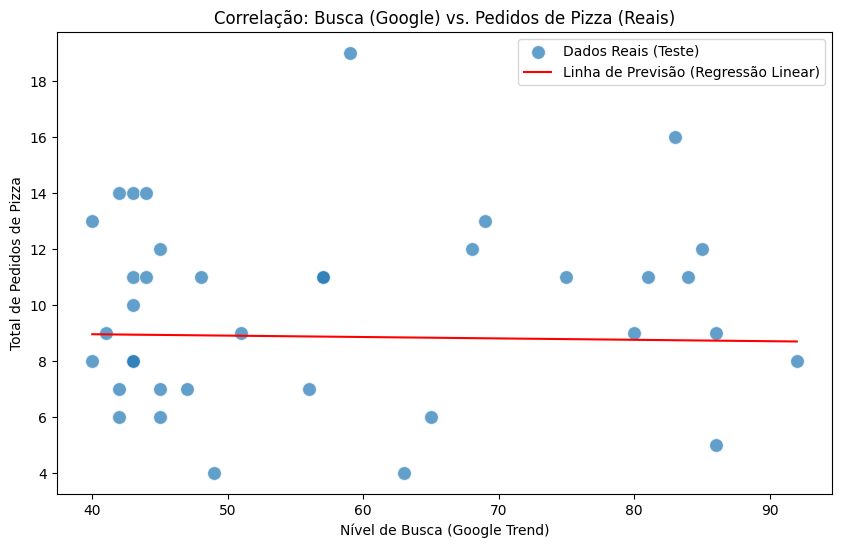

In [78]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['pizza_trend'], y=y_test, label='Dados Reais (Teste)', s=100, alpha=0.7)
sns.lineplot(x=X_test['pizza_trend'], y=y_pred_lr, color='red', label='Linha de Previsão (Regressão Linear)')
plt.title('Correlação: Busca (Google) vs. Pedidos de Pizza (Reais)')
plt.xlabel('Nível de Busca (Google Trend)')
plt.ylabel('Total de Pedidos de Pizza')
plt.legend()
plt.show()

### Célula 17: Modelo 2 (Avançado) - Random Forest Regressor
O `RandomForestRegressor` é mais potente e pode encontrar padrões não-lineares (relações mais complexas).

In [79]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
model_rf.fit(X_train, y_train)

print("Modelo 2 (Random Forest Regressor) treinado com sucesso!")

Modelo 2 (Random Forest Regressor) treinado com sucesso!


### Célula 18: Avaliação (Random Forest Regressor)

Avaliamos o modelo Random Forest. Como ele é mais complexo, podemos comparar seu R² com o do modelo linear.

In [80]:
y_pred_rf = model_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"--- Avaliação (Random Forest) ---")
print(f"Score R²: {r2_rf:.4f}")

print(f"\nComparação R²:")
print(f"Linear Regression: {r2_lr:.4f}")
print(f"Random Forest:     {r2_rf:.4f}")

--- Avaliação (Random Forest) ---
Score R²: -0.5557

Comparação R²:
Linear Regression: -0.0885
Random Forest:     -0.5557


### Célula 19: Visualização (Random Forest)

Para um modelo não-linear, o melhor gráfico é "Valores Reais vs. Valores Previstos". Se os pontos formarem uma linha reta diagonal perfeita, o modelo é perfeito.

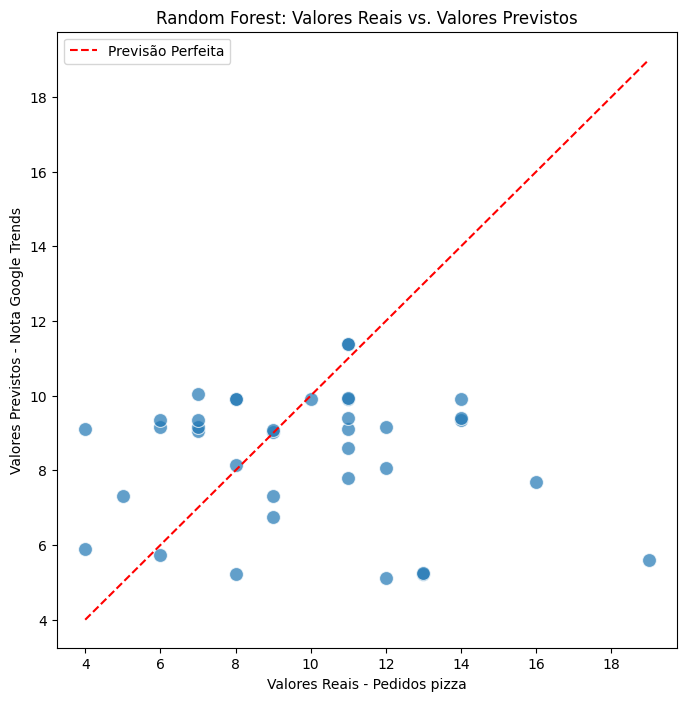

In [81]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_rf, s=100, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Previsão Perfeita')
plt.title('Random Forest: Valores Reais vs. Valores Previstos')
plt.xlabel('Valores Reais - Pedidos pizza')
plt.ylabel('Valores Previstos - Nota Google Trends')
plt.legend()
plt.show()